# KZ NOTE:

    Semi-auto-encoder: return the last layer latent space as compressed dv
    
# some notes:
    compressed_dv_semi_ae-v1: ResMLP with output activation. looks ok but maybe more easily interpretable if no output activation
    
    compressed_dv_semi_ae-v2: MLP and NO output activation: this is turns out to be kind of bad
    
    v3: try ResMLP without output activation (not as good as v1). Now v3 is v1 but smaller batch size

In [69]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [70]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [71]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16 #
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [72]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [73]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

In [74]:
# use only labels OMM, S8, A_IA

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Process data; with ZCA whitening

In [75]:
from compression_nn.preprocess import MinMaxNormalizer

In [76]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(pars_train)


Train with all 16 parameters.
max-min normalize the labels


In [77]:
num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices],
    train_y=pars_train[train_indices],
    val_x=dv[val_indices],
    val_y=pars_train[val_indices],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

In [78]:
train_loader

# Start Training!

In [11]:
## KZ this doesn't work; just to remind myself. Need to increase complexity?


# hyperparameter_configs = [
#     {
#         'test_id': 'Trf_test_v1',
#         'hidden_dims': [16, 1, 1, 64],
#         'dropout_rate': 0.2
#     },

#     {
#         'test_id': 'Trf_test_v1',
#         'hidden_dims': [16, 1, 4, 64],
#         'dropout_rate': 0.1
#     },
# ]

# ]

# for config in hyperparameter_configs:
#     model = CompressionNN(
#         input_dim=train_loader.dataset.tensors[0].shape[1],
#         output_dim=train_loader.dataset.tensors[1].shape[1],
#         test_id=config['test_id'],
#         hidden_dims=config['hidden_dims'],
#         dropout_rate=config['dropout_rate'],
#         output_act= torch.nn.Softplus(),
#         arch_name = 'Transformer'
#     )
    
#     model.zca = zca
#     train_losses, val_losses = model.fit(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         epochs=NUM_EPOCH,
#         early_stopping_patience=50,
#         loss_fun = torch.nn.L1Loss()
#     )

In [12]:
hyperparameter_configs = [
    ## KZ NOTE: kind of works but not really
    # {
    #     'test_id': 'Trf_test_v1',
    #     'hidden_dims': [64, 1, 1, 64],
    #     'dropout_rate': 0.1
    # },
    
    # {
    #     'test_id': 'Trf_test_v2',
    #     'hidden_dims': [64, 1, 2, 64],
    #     'dropout_rate': 0.1
    # },
    
    ### below kind of get loss=0.06
    
    {
        'test_id': 'Trf_test_v1',
        'hidden_dims': [32, 1, 2, 64],
        'dropout_rate': 0.1
    },
    
    {
        'test_id': 'Trf_test_v2',
        'hidden_dims': [32, 1, 2, 128],
        'dropout_rate': 0.1
    },
    
    {
        'test_id': 'Trf_test_v3',
        'hidden_dims': [32, 1, 4, 64],
        'dropout_rate': 0.1
    },
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'Transformer'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=10,
        loss_fun = torch.nn.L1Loss()
    )

Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  64


  0%|          | 1/300 [00:03<15:11,  3.05s/it]

Epoch 1/300:
Training Loss: 0.207829
Validation Loss: 0.210127


 17%|█▋        | 51/300 [02:17<11:46,  2.84s/it]

Epoch 51/300:
Training Loss: 0.123209
Validation Loss: 0.104626


 34%|███▎      | 101/300 [04:31<08:29,  2.56s/it]

Epoch 101/300:
Training Loss: 0.105952
Validation Loss: 0.080930


 55%|█████▌    | 166/300 [07:22<06:03,  2.71s/it]

Epoch 166/300:
Training Loss: 0.0969829
Validation Loss: 0.0801707


 56%|█████▌    | 167/300 [07:27<05:56,  2.68s/it]


Early stopping triggered after 168 epochs
Best validation loss is 0.07057359165929515
Model and preprocessing saved to models/model_Trf_test_v1.pkl
Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  128


  0%|          | 1/300 [00:02<14:09,  2.84s/it]

Epoch 1/300:
Training Loss: 0.208587
Validation Loss: 0.209833


 17%|█▋        | 51/300 [02:16<11:09,  2.69s/it]

Epoch 51/300:
Training Loss: 0.123808
Validation Loss: 0.119580


 34%|███▎      | 101/300 [04:31<09:19,  2.81s/it]

Epoch 101/300:
Training Loss: 0.119705
Validation Loss: 0.103124


 54%|█████▎    | 161/300 [07:14<06:14,  2.70s/it]


Early stopping triggered after 162 epochs
Best validation loss is 0.10182088202443616
Model and preprocessing saved to models/model_Trf_test_v2.pkl
Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  4
d_ff (Feed-forward network dimension) =  64


  0%|          | 1/300 [00:04<21:40,  4.35s/it]

Epoch 1/300:
Training Loss: 0.208556
Validation Loss: 0.211456


 17%|█▋        | 51/300 [03:55<18:11,  4.38s/it]

Epoch 51/300:
Training Loss: 0.171018
Validation Loss: 0.137077


 34%|███▎      | 101/300 [07:38<14:47,  4.46s/it]

Epoch 101/300:
Training Loss: 0.137587
Validation Loss: 0.102964


 55%|█████▌    | 166/300 [12:30<10:11,  4.57s/it]

Epoch 166/300:
Training Loss: 0.1364314
Validation Loss: 0.1012308


 57%|█████▋    | 172/300 [13:02<09:42,  4.55s/it]

Early stopping triggered after 173 epochs
Best validation loss is 0.10110152654092887
Model and preprocessing saved to models/model_Trf_test_v3.pkl


In [45]:
hyperparameter_configs = [
    {
        'test_id': 'Trf_test_v4',
        'hidden_dims': [32, 1, 2, 128],
        'dropout_rate': 0.0
    },
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'Transformer'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=10,
        loss_fun = torch.nn.L1Loss()
    )

Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  128


  0%|          | 1/300 [00:02<14:02,  2.82s/it]

Epoch 1/300:
Training Loss: 0.208933
Validation Loss: 0.213795


 17%|█▋        | 51/300 [02:04<09:56,  2.39s/it]

Epoch 51/300:
Training Loss: 0.100656
Validation Loss: 0.101890


 34%|███▎      | 101/300 [04:07<07:56,  2.39s/it]

Epoch 101/300:
Training Loss: 0.069492
Validation Loss: 0.069617


 55%|█████▌    | 166/300 [06:51<05:42,  2.56s/it]

Epoch 166/300:
Training Loss: 0.0656093
Validation Loss: 0.0681253


 60%|██████    | 181/300 [07:29<04:53,  2.47s/it]

Epoch 181/300:
Training Loss: 0.0623328
Validation Loss: 0.0650456


 61%|██████▏   | 184/300 [07:38<04:49,  2.49s/it]

Early stopping triggered after 185 epochs
Best validation loss is 0.0649136798777457
Model and preprocessing saved to models/model_Trf_test_v4.pkl


In [68]:
hyperparameter_configs = [
    {
        'test_id': 'Trf_test_v5',
        'hidden_dims': [16, 1, 2, 128],
        'dropout_rate': 0.0
    },
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'Transformer'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=10,
        loss_fun = torch.nn.L1Loss()
    )

Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  16
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  128


  0%|          | 1/300 [00:02<11:54,  2.39s/it]

Epoch 1/300:
Training Loss: 0.206930
Validation Loss: 0.211118


 17%|█▋        | 51/300 [02:03<09:58,  2.40s/it]

Epoch 51/300:
Training Loss: 0.101879
Validation Loss: 0.105842


 34%|███▎      | 101/300 [04:03<07:53,  2.38s/it]

Epoch 101/300:
Training Loss: 0.098060
Validation Loss: 0.101584


 55%|█████▌    | 166/300 [06:43<05:47,  2.59s/it]

Epoch 166/300:
Training Loss: 0.0964327
Validation Loss: 0.1005149


 58%|█████▊    | 173/300 [07:03<05:10,  2.45s/it]

Early stopping triggered after 174 epochs
Best validation loss is 0.10047682760090663
Model and preprocessing saved to models/model_Trf_test_v5.pkl


In [81]:
hyperparameter_configs = [
    {
        'test_id': 'Trf_test_v6',
        'hidden_dims': [32, 1, 2, 128],
        'dropout_rate': 0.0
    },
    
    {
        'test_id': 'Trf_test_v7',
        'hidden_dims': [32, 1, 4, 128],
        'dropout_rate': 0.0
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'Transformer'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=10,
        loss_fun = torch.nn.L1Loss()
    )

Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  128


  0%|          | 1/300 [00:02<12:04,  2.42s/it]

Epoch 1/300:
Training Loss: 0.207952
Validation Loss: 0.212090


 17%|█▋        | 51/300 [02:05<10:00,  2.41s/it]

Epoch 51/300:
Training Loss: 0.101834
Validation Loss: 0.100333


 34%|███▎      | 101/300 [04:05<07:52,  2.38s/it]

Epoch 101/300:
Training Loss: 0.075421
Validation Loss: 0.073812


 54%|█████▎    | 161/300 [06:34<05:40,  2.45s/it]


Early stopping triggered after 162 epochs
Best validation loss is 0.06622000623109012
Model and preprocessing saved to models/model_Trf_test_v6.pkl
Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  4
d_ff (Feed-forward network dimension) =  128


  0%|          | 1/300 [00:04<20:22,  4.09s/it]

Epoch 1/300:
Training Loss: 0.208651
Validation Loss: 0.207199


 17%|█▋        | 51/300 [03:30<17:04,  4.12s/it]

Epoch 51/300:
Training Loss: 0.154572
Validation Loss: 0.156017


 34%|███▎      | 101/300 [06:56<13:34,  4.09s/it]

Epoch 101/300:
Training Loss: 0.152060
Validation Loss: 0.152848


 55%|█████▌    | 166/300 [11:28<09:23,  4.20s/it]

Epoch 166/300:
Training Loss: 0.0992793
Validation Loss: 0.1013299


 55%|█████▌    | 166/300 [11:32<09:19,  4.17s/it]

Early stopping triggered after 167 epochs
Best validation loss is 0.10071053458698864
Model and preprocessing saved to models/model_Trf_test_v7.pkl


# plot validations

In [82]:
from compression_nn.utils import plot_test_error

In [83]:
def plot_test_error_all_param_TEST(model, test_loader, n_params, label_normalizer=None, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=range(n_params)

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    points = 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model.predict(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            if isinstance(y_NN, torch.Tensor):
                y_NN = y_NN.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN

            points    += x.shape[0]
            
    # inverse-normalization if needed
    if label_normalizer is not None:
        params_NN   = label_normalizer.inverse_transform(params_NN)

    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    # KZ: let me first assume n_params is even 
    f, axarr = plt.subplots(1, 3, figsize=(20,10))
    
    for i in range(n_params):
        # if i%2==0:
        row_idx = i
        print('test', i)
        axarr[row_idx].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

        axarr[row_idx].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
        axarr[row_idx].set_xlabel(r"True param "+str(i))
        axarr[row_idx].set_ylabel(r"Predicted param "+ str(i))

        axarr[row_idx].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx].transAxes)
        axarr[row_idx].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx].transAxes)

#         else:
#             row_idx = i//2
            
#             axarr[row_idx,1].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

#             axarr[row_idx,1].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
#             axarr[row_idx,1].set_xlabel(r"True param "+str(i))
#             axarr[row_idx,1].set_ylabel(r"Predicted param "+ str(i))

#             axarr[row_idx,1].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
#             axarr[row_idx,1].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            
    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

In [ ]:
loaded_model = CompressionNN.load('Trf_test_v4')
loaded_model.model.to('cpu')

plot_test_error_all_param_TEST(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


Transformers Architectures: (note the difference with MLP in hidden-dims)
d_model (Model dimension) =  32
num_heads (Number of attention heads) =  1
num_layers (Number of transformer blocks) =  2
d_ff (Feed-forward network dimension) =  128


In [50]:
test_full_dv = test_loader.dataset.tensors[0]
print(test_full_dv.shape)

torch.Size([8187, 608])


In [51]:
compressed_dv_semi_ae = []
for i in range(test_full_dv.shape[0]):
    compressed_dv_semi_ae.append(loaded_model.get_last_hidden_layer(test_full_dv[i].reshape((1,-1))))

compressed_dv_semi_ae = np.array(compressed_dv_semi_ae)

In [52]:
compressed_dv_semi_ae.shape

(8187, 1, 32)

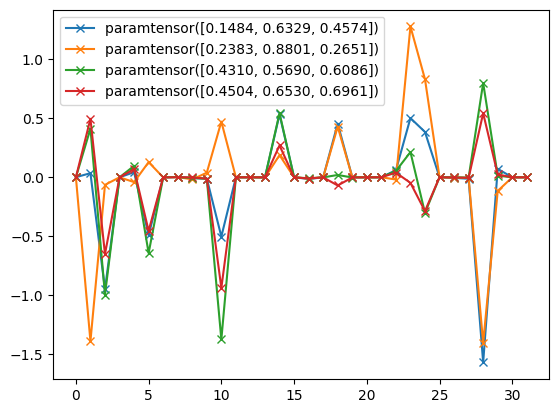

In [53]:
for i in [1,5,20,10]:
    plt.plot(compressed_dv_semi_ae[i][0], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
plt.legend()

# Test at fiducial cosmology

In [61]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]

# dv_compressed_fid = loaded_model.predict(dv_set_fid)
# dv_compressed_fid = label_normalizer.inverse_transform(dv_compressed_fid)

In [62]:
# plt.scatter(dv_compressed_fid[:,0], dv_compressed_fid[:,1])

In [63]:
# target_compressed_dv = np.mean(dv_compressed_fid, axis=0)

In [64]:
dv_compressed_fid_ae = []
for i in range(dv_set_fid.shape[0]):
    dv_compressed_fid_ae.append(loaded_model.get_last_hidden_layer(dv_set_fid[i].reshape((1,-1))))
dv_compressed_fid_ae = np.array(dv_compressed_fid_ae)


dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae,axis=0)

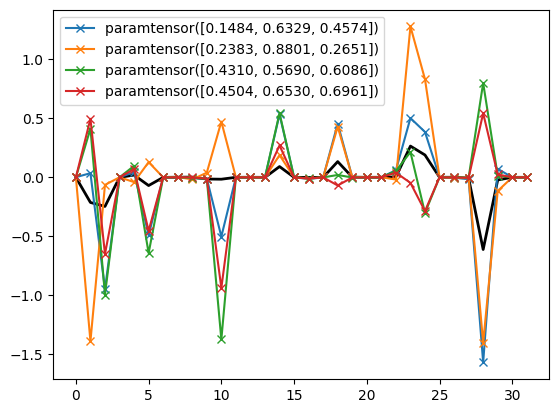

In [65]:
plt.plot(dv_compressed_fid_ae[0],c='black',lw=2)

for i in [1,5,20,10]:
    plt.plot(compressed_dv_semi_ae[i][0], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
plt.legend()

In [66]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

((8187, 1, 32), (1, 32))

In [67]:
np.save('./output/sims_compressed_TrF_v1', compressed_dv_semi_ae.reshape((compressed_dv_semi_ae.shape[0], compressed_dv_semi_ae.shape[-1])))
np.save('./output/fid_compressed_TrF_v1', dv_compressed_fid_ae.flatten())